In [1]:
!git clone https://github.com/XL2248/MSCTD.git

Cloning into 'MSCTD'...
remote: Enumerating objects: 1217, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1217 (delta 13), reused 7 (delta 3), pack-reused 1190
Receiving objects: 100% (1217/1217), 102.24 MiB | 16.90 MiB/s, done.
Resolving deltas: 100% (617/617), done.
Checking out files: 100% (934/934), done.


In [2]:
#!gdown --id 1GAZgPpTUBSfhne-Tp0GDkvSHuq6EMMbj


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip "/content/drive/MyDrive/DeepLearning_Project/train_ende.zip"
!unzip "/content/drive/MyDrive/DeepLearning_Project/test.zip"
!unzip "/content/drive/MyDrive/DeepLearning_Project/dev.zip"


Streaming output truncated to the last 5000 lines.
  inflating: dev/1054.jpg            
  inflating: dev/1055.jpg            
  inflating: dev/1056.jpg            
  inflating: dev/1057.jpg            
  inflating: dev/1058.jpg            
  inflating: dev/1059.jpg            
  inflating: dev/106.jpg             
  inflating: dev/1060.jpg            
  inflating: dev/1061.jpg            
  inflating: dev/1062.jpg            
  inflating: dev/1063.jpg            
  inflating: dev/1064.jpg            
  inflating: dev/1065.jpg            
  inflating: dev/1066.jpg            
  inflating: dev/1067.jpg            
  inflating: dev/1068.jpg            
  inflating: dev/1069.jpg            
  inflating: dev/107.jpg             
  inflating: dev/1070.jpg            
  inflating: dev/1071.jpg            
  inflating: dev/1072.jpg            
  inflating: dev/1073.jpg            
  inflating: dev/1074.jpg            
  inflating: dev/1075.jpg            
  inflating: dev/1076.jpg            

# DataLoader

In [5]:
import os
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import Dataset
import cv2 as cv
import numpy as np
import cv2
import dlib



In [6]:
# english_dev : 5063
# english_test : 5067
# english_train : 20240
# #--------------------
# german_dev : 5063
# german_test : 5067
# german_train : 20240
# #-------------------

In [7]:
y_h = lambda y : torch.zeros(3, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1)
class MSCTDDataset(Dataset):
    
    def __init__(self, path_to_dataset = None, transform=None, target_transform=None):
        if path_to_dataset == 'path_to_dataset_train':
            Data = 'train'
            path_english_text = 'english_train'
            path_sentiment_text = 'sentiment_train'
            path_image = 'train_ende'
        elif path_to_dataset == 'path_to_dataset_test':
            Data = 'test'
            path_download = 'test_ende'
            path_english_text = 'english_test'
            path_sentiment_text = 'sentiment_test'
            path_image = 'test'
        elif path_to_dataset == 'path_to_dataset_dev':
            Data = 'dev'
            path_download = 'dev'
            path_english_text = 'english_dev'
            path_sentiment_text = 'sentiment_dev'
            path_image = 'dev'
        else:
            return TypeError, path_to_dataset + " is invalid"
        #!unzip "/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/deepproject/train_ende.zip"
        english_text_path = f"/content/MSCTD/MSCTD_data/ende/{path_english_text}.txt"
        sentiment_path = f"/content/MSCTD/MSCTD_data/ende/{path_sentiment_text}.txt"
        self.image_path = f"/content/{path_image}/"

        with open(english_text_path) as f:
          english_text = [line.strip() for line in f.readlines()]
        print(f"{Data} english_text", len(english_text))
        self.englishtext = english_text

        with open(sentiment_path) as f:
          sentiment = [line.strip() for line in f.readlines()]
        self.sentiment = sentiment
        print(f"{Data} sentiment", len(sentiment))
        
        Images = os.listdir(self.image_path)
        Images.sort(key = lambda x:  int(x.split(".")[0]))
        self.Images = Images
        # self.target = target
        # self.features = features
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.sentiment)

    def __getitem__(self, idx):

        img_path = os.path.join(self.image_path, self.Images[idx])

        img = cv.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   # Chnage channel due to imread function read images in BGR coding.
        sntmnt = self.sentiment[idx]
        englsh_txt = self.englishtext[idx]

        if self.target_transform:
            label = y_h(sntmnt)
        return img, englsh_txt, sntmnt 

In [8]:
train = MSCTDDataset('path_to_dataset_train', target_transform = False)
test = MSCTDDataset('path_to_dataset_test', target_transform = False)
dev = MSCTDDataset('path_to_dataset_dev', target_transform = False)

train english_text 20240
train sentiment 20240
test english_text 5067
test sentiment 5067
dev english_text 5063
dev sentiment 5063


In [9]:
image, en_text, sentiment = train[4452]

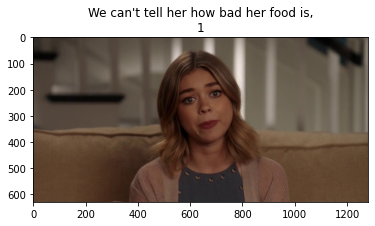

In [10]:
plt.title(en_text+"\n" + sentiment)
plt.imshow(image)

# Dataset Interpretation

## Part0 : DataLoader split sections for each set

**We put this section to split text and sentiment classes for train, dev and test set. regard of RAM limitation, we can't save images in a numpy array or tensor** 

**It takes about 10 minutes**

In [11]:
text_list = []
sentiment_list = []
def split(label_set, dataloader):
    length = len(dataloader)
    text = []
    sentiment = np.zeros((length))
    for i in range(length):
        text.append(dataloader[i][1])
        sentiment[i] = dataloader[i][2]
    text_list.append(text)
    sentiment_list.append(sentiment)

split("train", train)
split("test", test)
split("dev", dev)

In [12]:
print(f"sentiment_list is: {len(sentiment_list)}")
print(f"text_list is: {len(text_list)}")

sentiment_list is: 3
text_list is: 3


## Part1 : Histogram of data based on sentiments

**Interpretation** : This histogram shows the distribution of classes. with this plot, we intuit whether use data augmentation or balance dataset methods before training procedure. From hitogram plots, we can see that test_set have different distribution in comparision with train and dev sets for class 0.

In [13]:
def sentiemnt_histogram(set_label, snetiment_array):

    plt.title(f"Histogram of {set_label}_set sentiment classes")
    plt.bar(*np.unique(snetiment_array, return_counts=True))



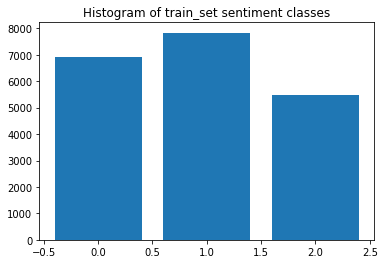

In [14]:
# Train

sentiemnt_histogram("train", sentiment_list[0])

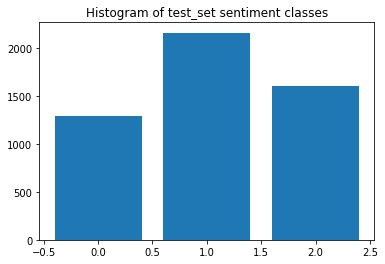

In [15]:
# Test
sentiemnt_histogram("test", sentiment_list[1])

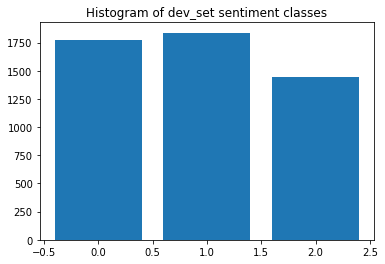

In [16]:
# Dev
sentiemnt_histogram("dev", sentiment_list[2])

## Part2: Histogram, Mean and Variance of sentences

**Interpretation** : Variance and mean of the sentences (length of the words) are important parameters in future RNN train procedure, these values may be used for data normalization.


In [17]:
def text_histogram(set_label, text):
    text_length = np.zeros((len(text)))
    for i in range(len(text)):
        text_length[i] = len(text[i].split(" "))

    print(f"Mean value of {set_label}_set sentences (based on words) is: {np.mean(text_length)}")
    print(f"Var value of {set_label}_set sentences (based on words) is: {np.var(text_length)}")

    plt.title(f"Histogram of {set_label}_set sentences (based on words)")
    plt.bar(*np.unique(text_length, return_counts=True))

Mean value of train_set sentences (based on words) is: 6.4644268774703555
Var value of train_set sentences (based on words) is: 9.247252339514754


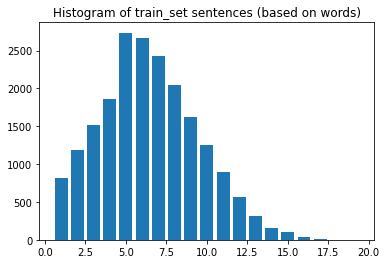

In [18]:
#Train 

text_histogram("train", text_list[0])

Mean value of test_set sentences (based on words) is: 6.303927373199132
Var value of test_set sentences (based on words) is: 8.892826494034605


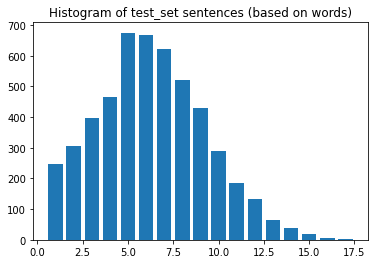

In [19]:
#Test

text_histogram("test", text_list[1])

Mean value of dev_set sentences (based on words) is: 6.310290341694648
Var value of dev_set sentences (based on words) is: 8.630759208611043


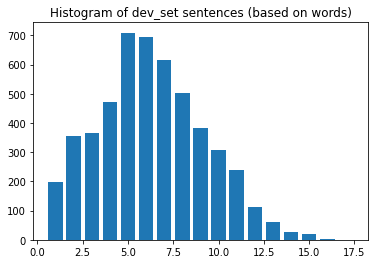

In [20]:
#Dev

text_histogram("dev", text_list[2])

## Part3 : Histogram, Mean and Variance number of images in each converstation

**Note : We did not locate image series of converstations in DataLoader. Based on future phases, we decide to whether put this section in Dataloader or not.**

**Interpretation** : like sentences, this parameter may be used for normalization.

In [21]:
def converstation_histogram(set_label, index_path):
    with open(index_path) as f:
        converstations = f.readlines()
    line_arrays = np.zeros((len(converstations)))
    for index in range(len(converstations)):
        line_arrays[index] = len(converstations[index].split(","))
    print(f"Mean value of {set_label}_set based on number of images in converstation is: {np.mean(line_arrays)}")
    print(f"Var value of {set_label}_set based on number of images in converstation is: {np.var(line_arrays)}")

    plt.title(f"Histogram of {set_label}_set based on number of images in converstation is: ")
    plt.bar(*np.unique(line_arrays, return_counts=True))

Mean value of train_set based on number of images in converstation is: 9.796708615682478
Var value of train_set based on number of images in converstation is: 17.69632992187156


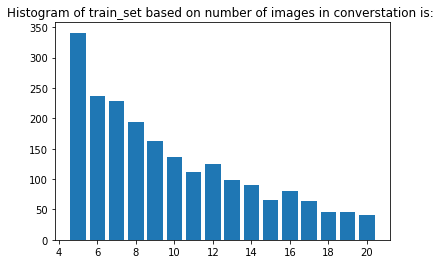

In [22]:
# Train
train_index_path = '/content/MSCTD/MSCTD_data/ende/image_index_train.txt'
converstation_histogram('train', train_index_path)

Mean value of test_set based on number of images in converstation is: 9.954813359528487
Var value of test_set based on number of images in converstation is: 17.752378599742936


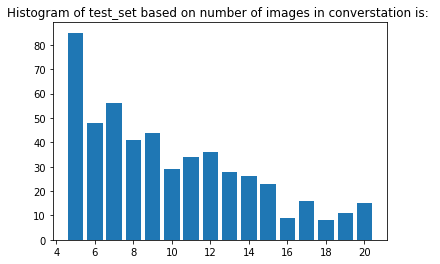

In [23]:
# Test
test_index_path = '/content/MSCTD/MSCTD_data/ende/image_index_test.txt'
converstation_histogram('test', test_index_path)

Mean value of dev_set based on number of images in converstation is: 10.045634920634921
Var value of dev_set based on number of images in converstation is: 19.253869834971024


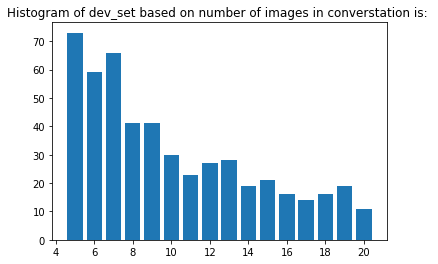

In [24]:
# Dev
dev_index_path = '/content/MSCTD/MSCTD_data/ende/image_index_dev.txt'
converstation_histogram('dev', dev_index_path)

## Part4: Histogram, Mean and Variance of faces in each image

**Interpretation** : The important parameter which is effective in computer vision task is number of faces in each image, as we see in this histogram, up to 70% of images have 2 or more faces and this parameter may make problem when we want predict sentiment classes by these images.

**It takes about 60 minutes**

In [25]:
def image_histogram(set_label, dataloader):
    image_count = []
    detector = dlib.get_frontal_face_detector()
    for i in range(len(dataloader)):
        image = dataloader[i][0]
        numberOffaces = detector(image)
        image_count.append(len(numberOffaces))

    ArrayImageCount = np.array(image_count)
    print(f"Mean value of {set_label}_set based on number of faces in images is: {np.mean(ArrayImageCount)}")
    print(f"Var value of {set_label}_set based on number of faces in images is: {np.var(ArrayImageCount)}")

    plt.title(f"Histogram of {set_label}_set based on number of faces in images is")
    plt.bar(*np.unique(ArrayImageCount, return_counts=True))




Mean value of train_set based on number of faces in images is: 0.6770750988142292
Var value of train_set based on number of faces in images is: 0.7564902591823025


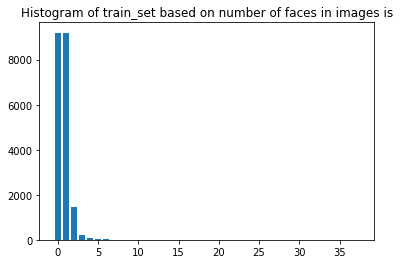

In [26]:
# Train
# It takes about 40 minutes

image_histogram("train", train)

Mean value of test_set based on number of faces in images is: 0.738898756660746
Var value of test_set based on number of faces in images is: 0.5382993990649629


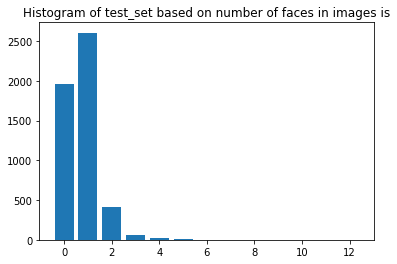

In [27]:
# Test
# It takes about 10 minutes

image_histogram("test", test)

Mean value of dev_set based on number of faces in images is: 0.6539601027059055
Var value of dev_set based on number of faces in images is: 0.45027416550281385


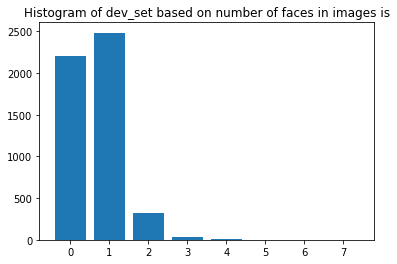

In [28]:
# Dev
# It takes about 10 minutes

image_histogram("dev", dev)